In [1]:
import os
import essentia as ess
import essentia.standard as estd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Defining some constants

ANALYZE_SOUND_FRAME_SIZE = 512 # Surce sound analysis frame sizes
HOP_SIZE = 256 # Parameter used by the "FrameGenerator" and "FFT" functions
GUESS_UNVOICED = True  # Read the algorithm's reference for more detail

DATASET_FOLDER = "adc2004_full_set"

DATASET_PATH = "../data/" + DATASET_FOLDER

ERROR_TXT_FILE = DATASET_PATH + '/error.txt'

In [2]:
def process_file(filename, path, errorcav_path = ERROR_TXT_FILE, frame_size=ANALYZE_SOUND_FRAME_SIZE, hop_size=HOP_SIZE):
    """
    filename without extension
    """
    audio_path = path + '/' + filename + '.wav'
    csv_og_path = path + '/' + filename + 'REF.txt'
    csv_dest_path = path + '/' + filename + '_err.csv'
    plot_path = path + '/' + filename + '.png'

    audio = estd.EqloudLoader(filename = audio_path, sampleRate = 44100)()

    #aqui anira el nostre feature extractor
    pitch_extractor = estd.PredominantPitchMelodia(frameSize=frame_size, hopSize=hop_size)
    pitch_values, pitch_confidence = pitch_extractor(audio)
    #fins aqui
    """
    pitch_confidence = pitch_confidence/max(pitch_confidence)
    mask = pitch_confidence<0.35
    pitch_confidence[mask] = 0
    pitch_values[mask] = 0.0
    """
    with open(csv_og_path) as tsvfile:

        # Reading the TSV's
        frames = pd.read_csv(tsvfile, delimiter='     ', names =['time(ms)','pitch_reference'],index_col = 'time(ms)')
    
    if frames.shape[0] < len(pitch_values): 
        pitch_values = pitch_values[:frames.shape[0]]
    elif frames.shape[0] > len(pitch_values): 
        for _ in range(frames.shape[0]-len(pitch_values)):
            pitch_values.append(0)
    
    frames["pitch_prediction"] = pitch_values
    frames["deviation"] = abs(frames["pitch_reference"] - frames["pitch_prediction"])

    frames.plot(subplots=True, layout=(3,1),figsize = (15,20));
    plt.savefig(plot_path);
    
    err_sum = sum(frames["deviation"].tolist())/frames["deviation"].count()

    with open(csv_dest_path,'w') as csvfile:
        frames.to_csv(csvfile, sep = '\t')

    with open(ERROR_TXT_FILE,"a") as txtfile:
        txtfile.write(filename + '\t' + str(err_sum) + '\n')
        

Processing Files...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


All files were processed successfully


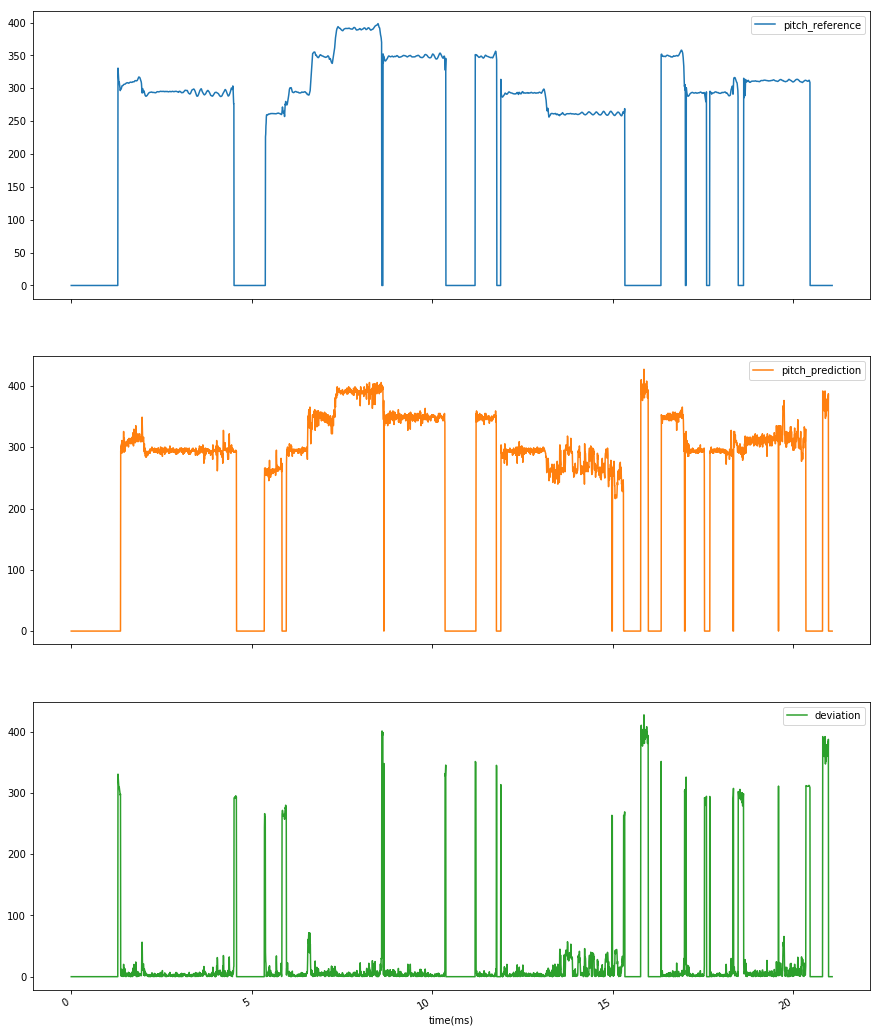

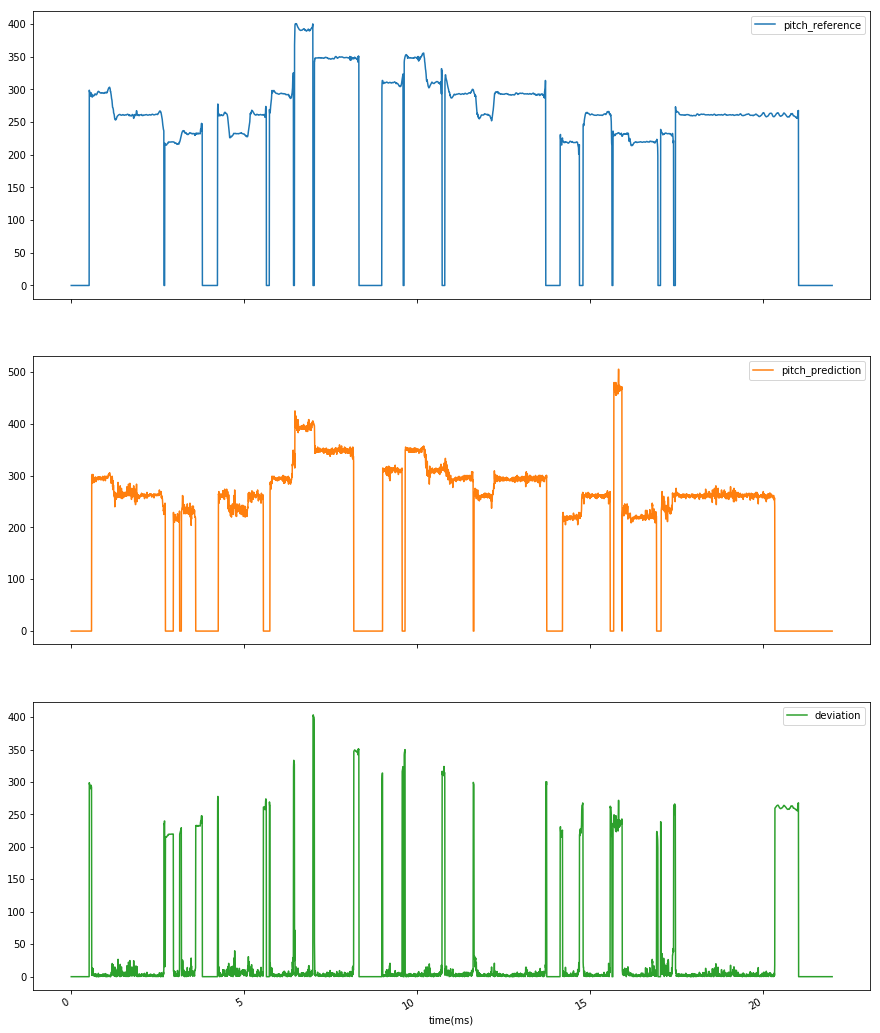

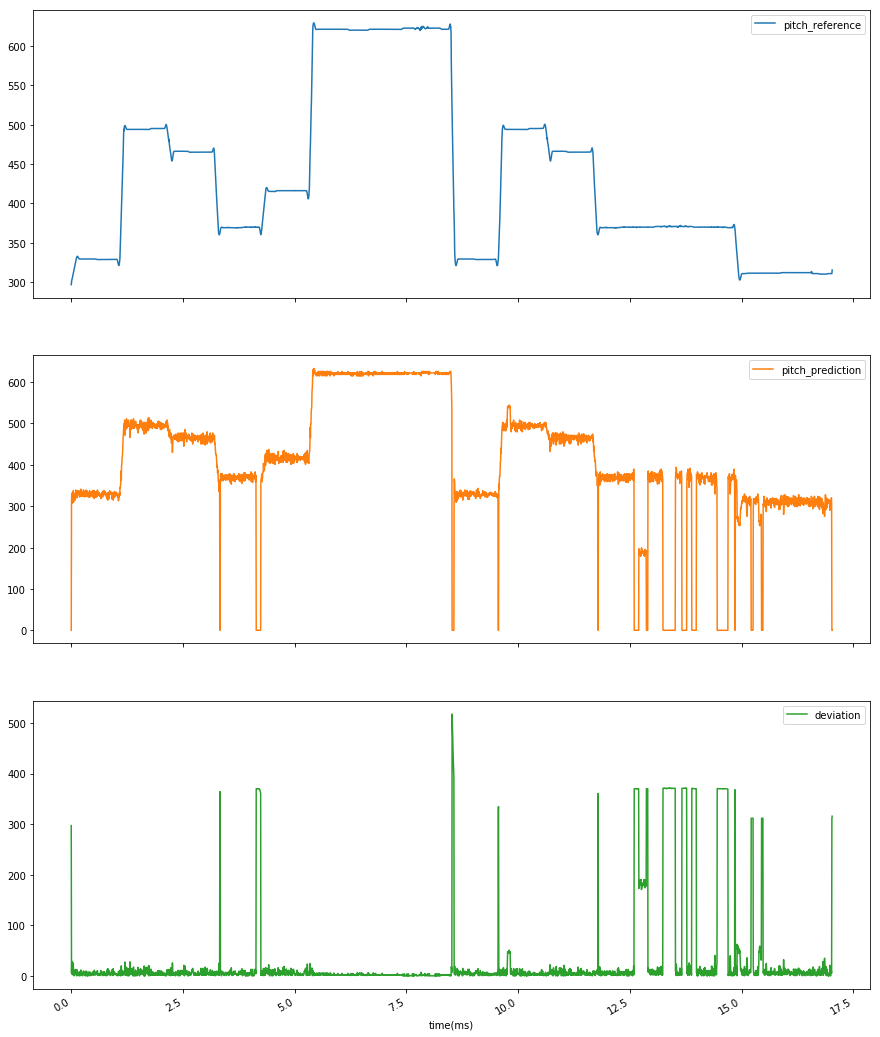

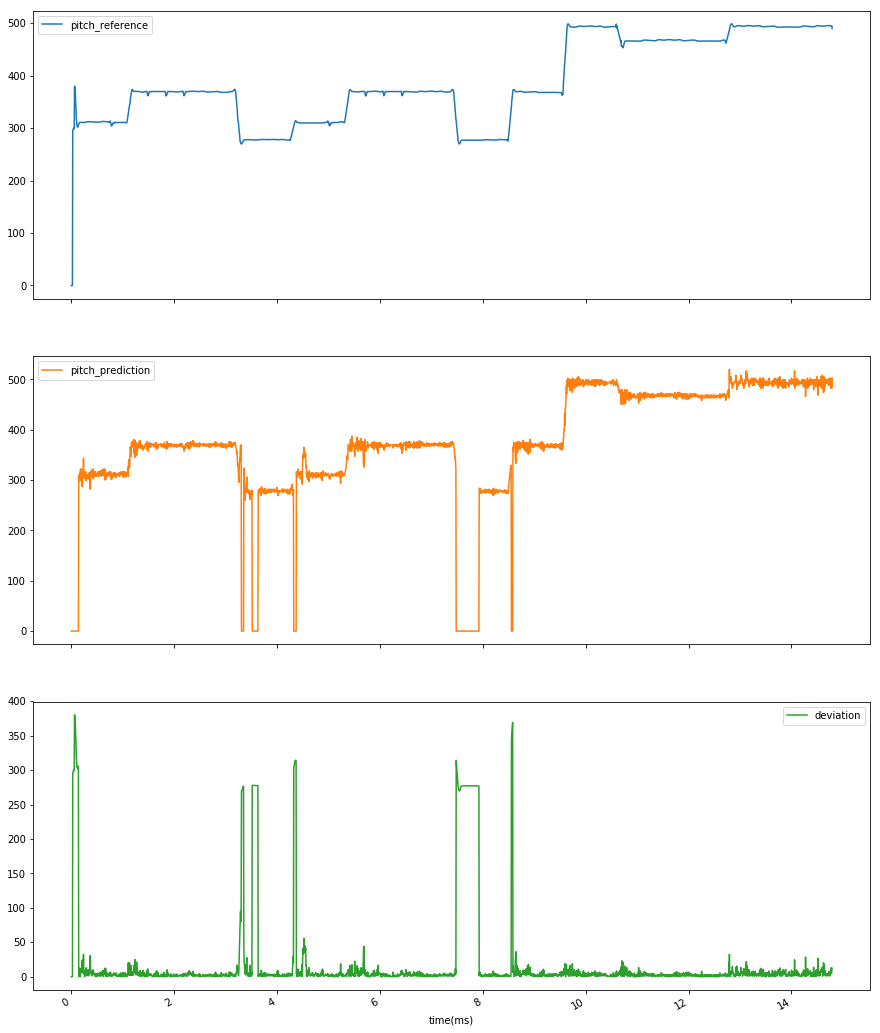

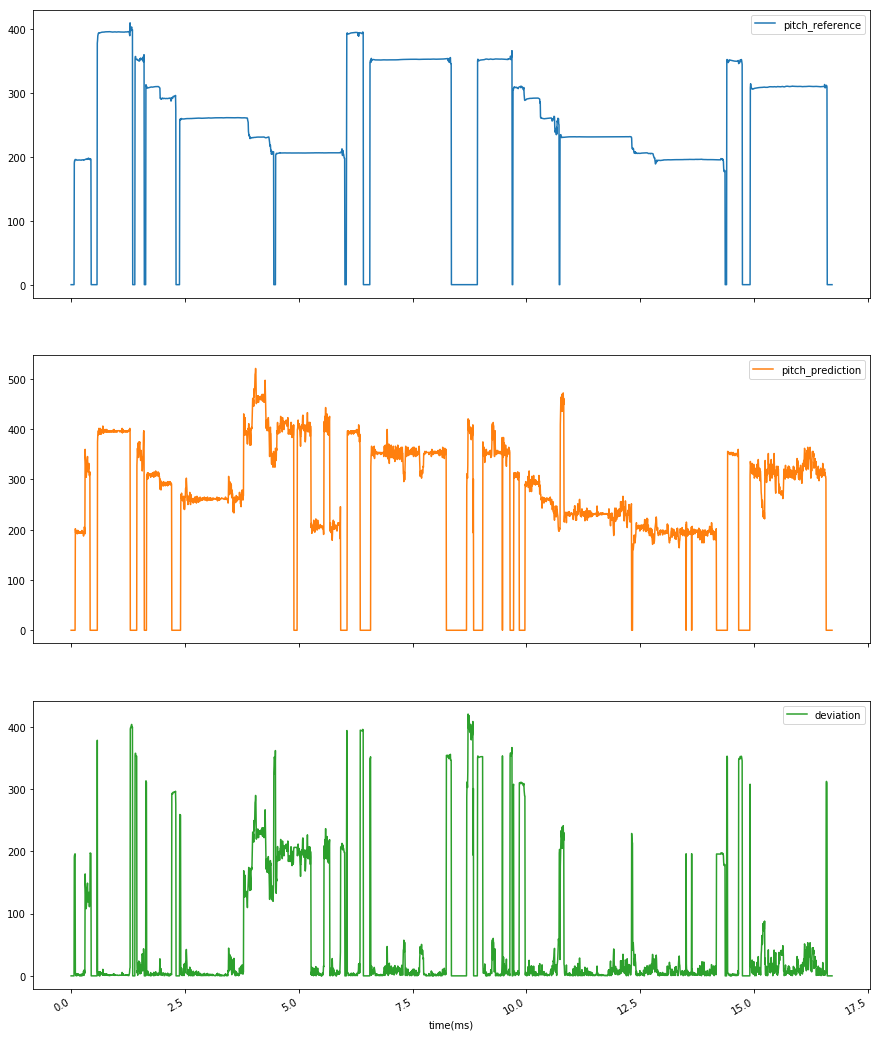

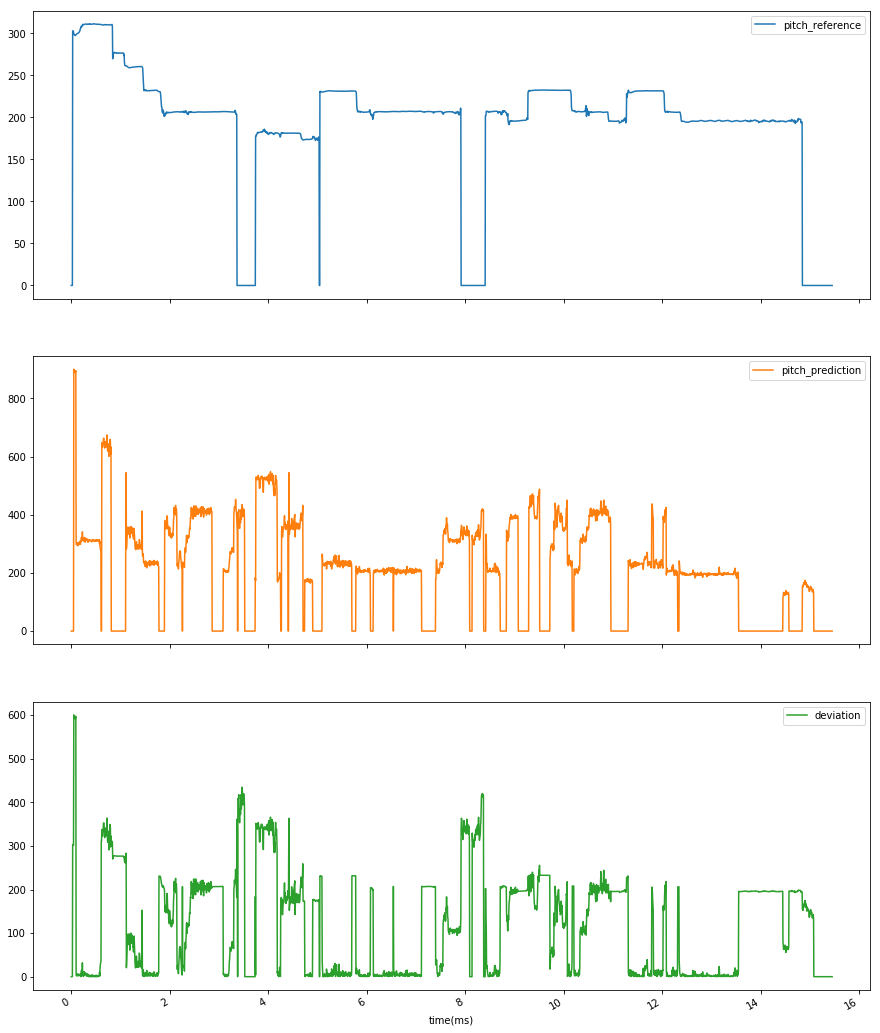

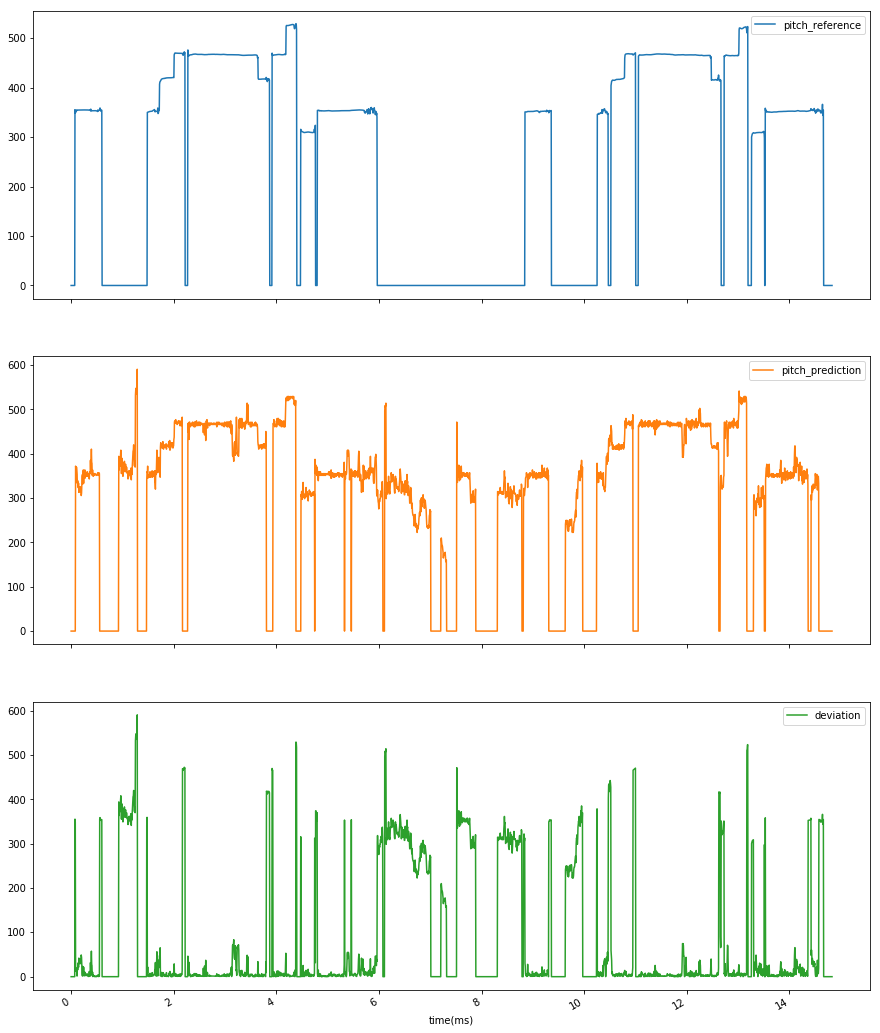

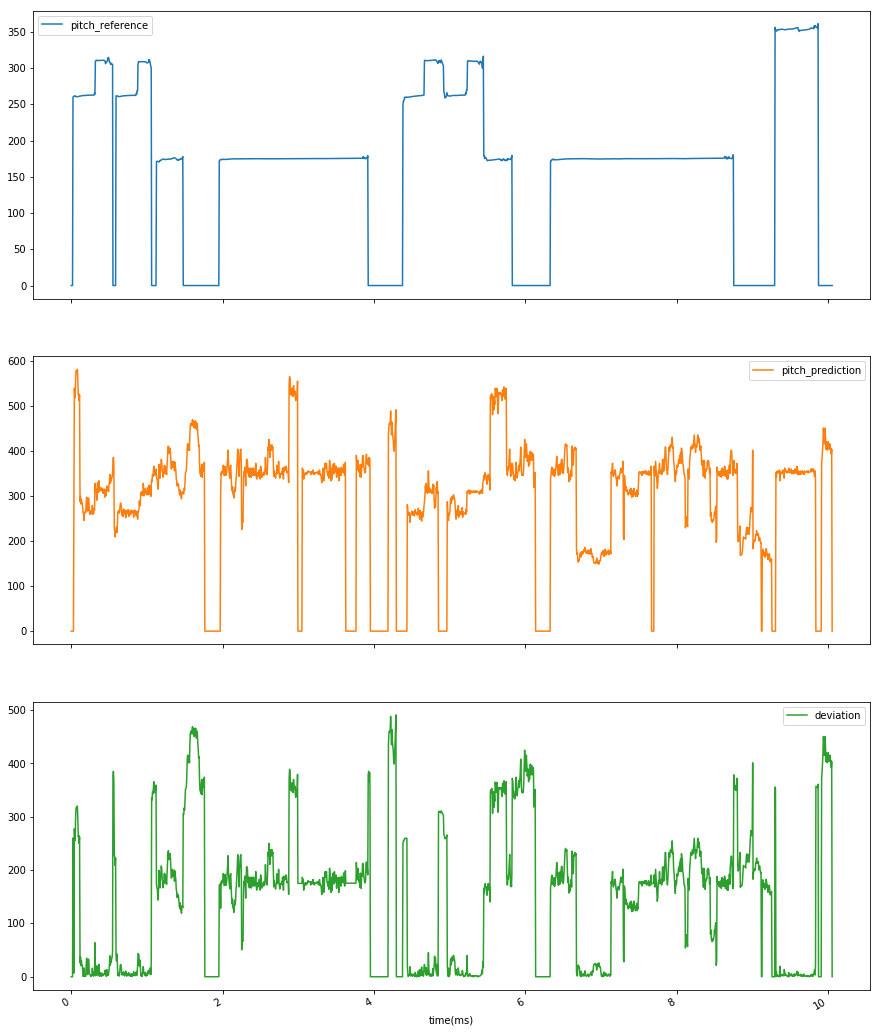

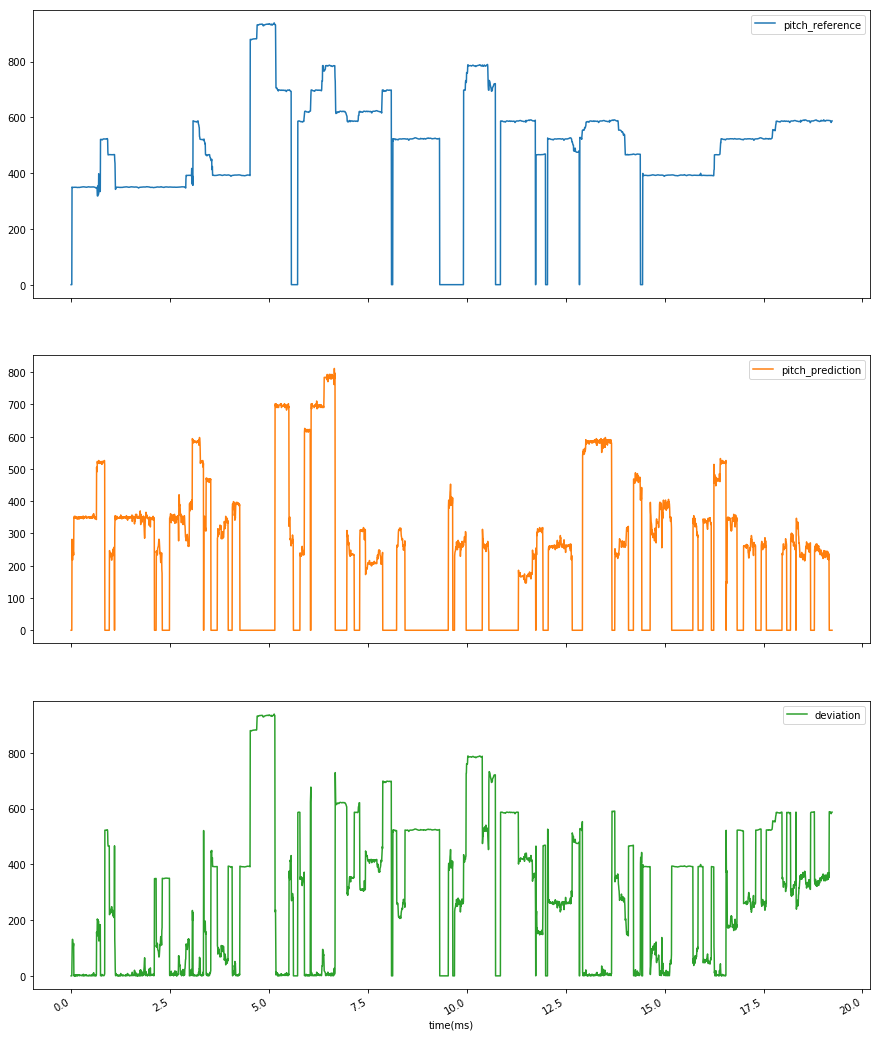

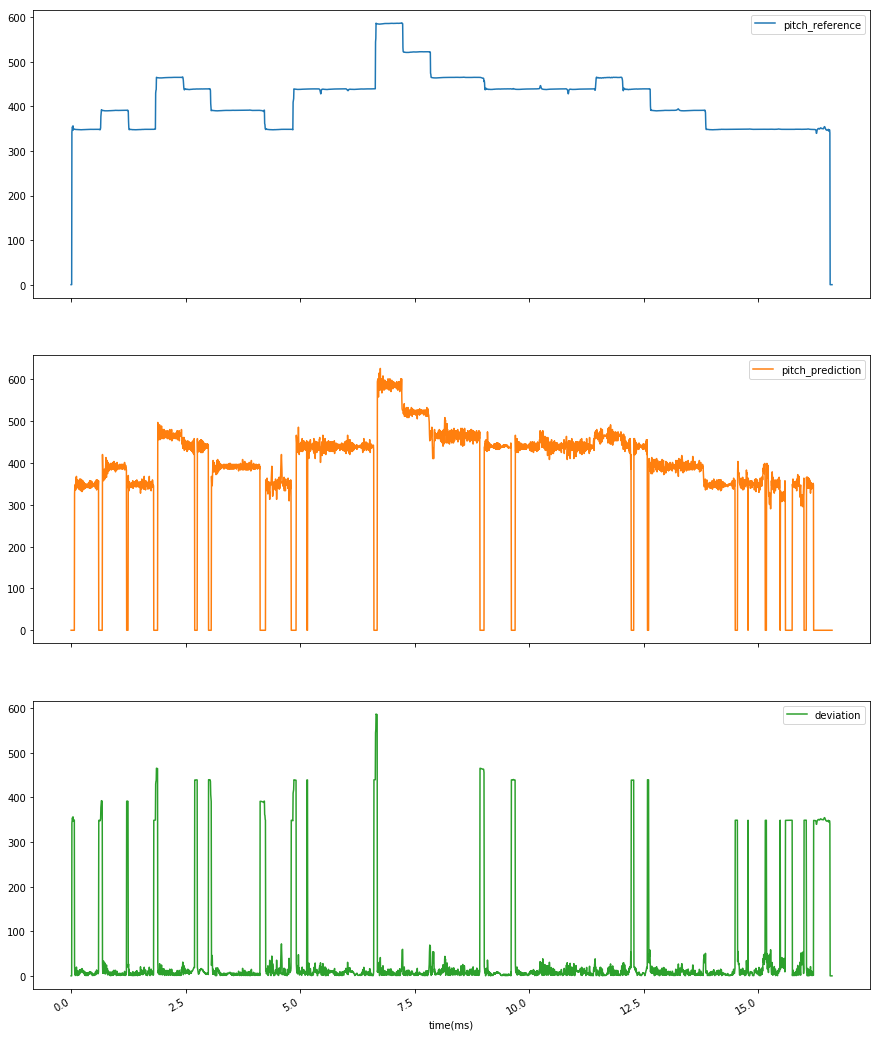

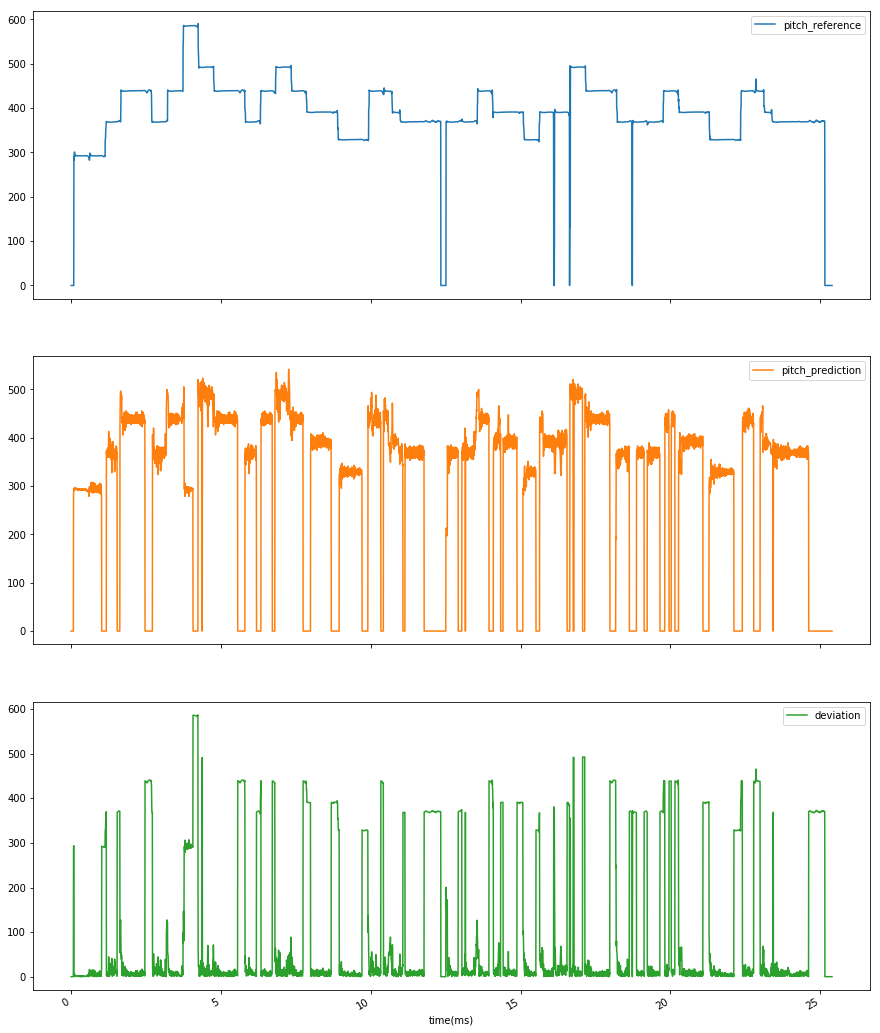

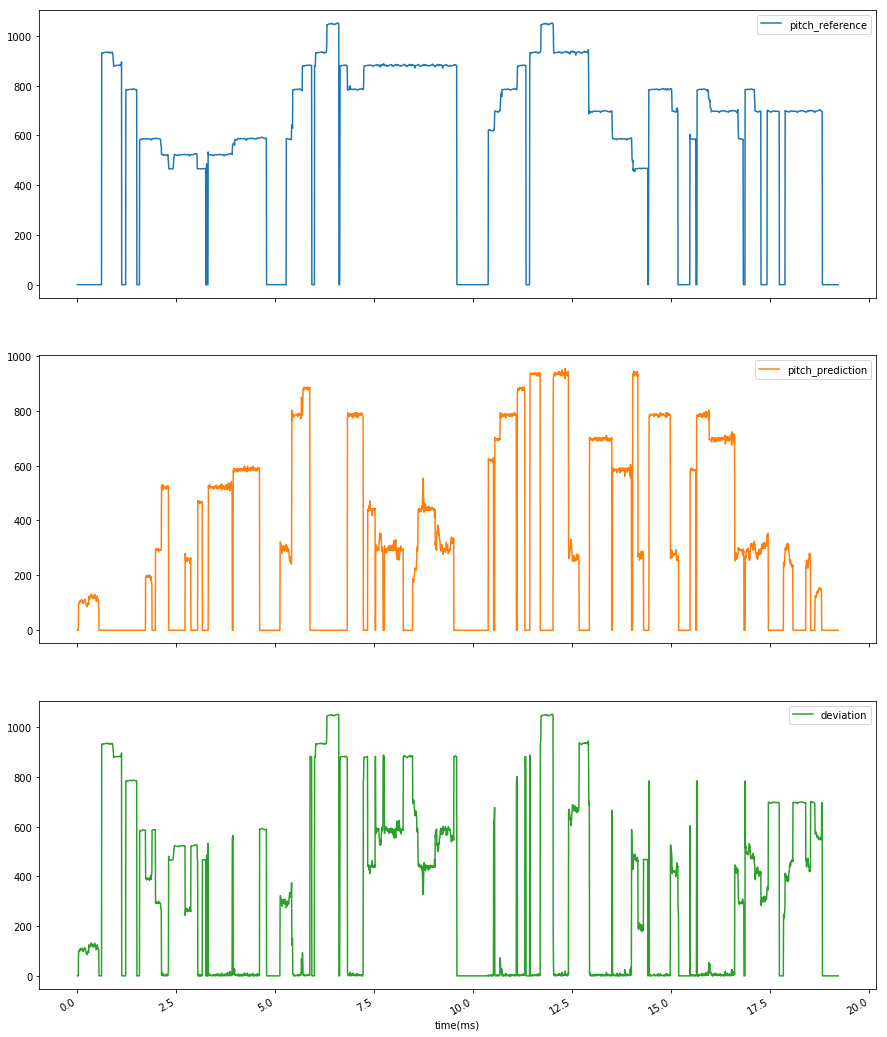

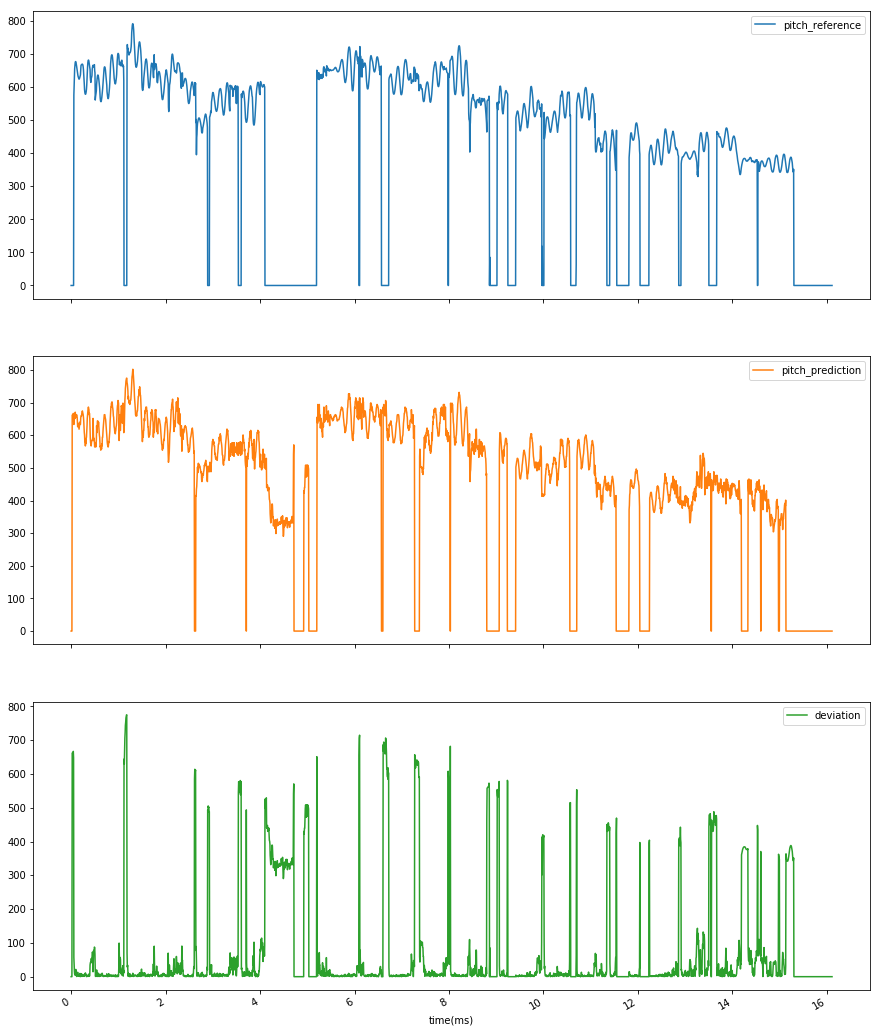

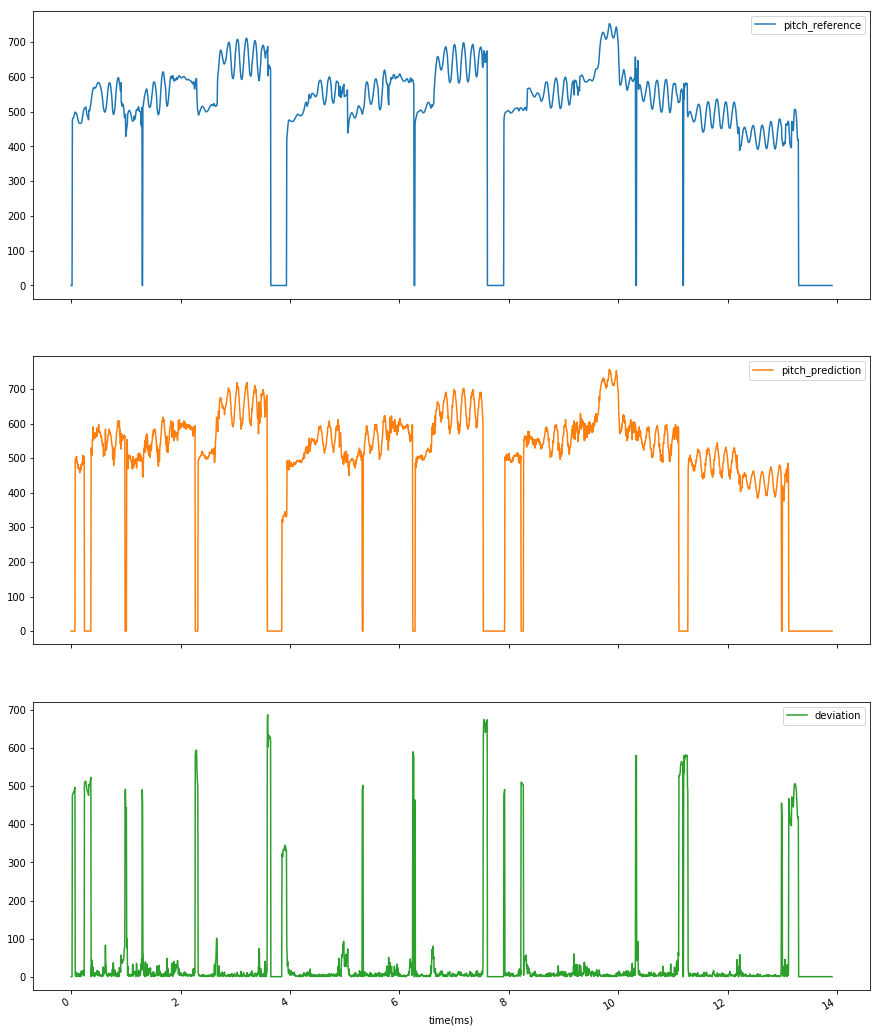

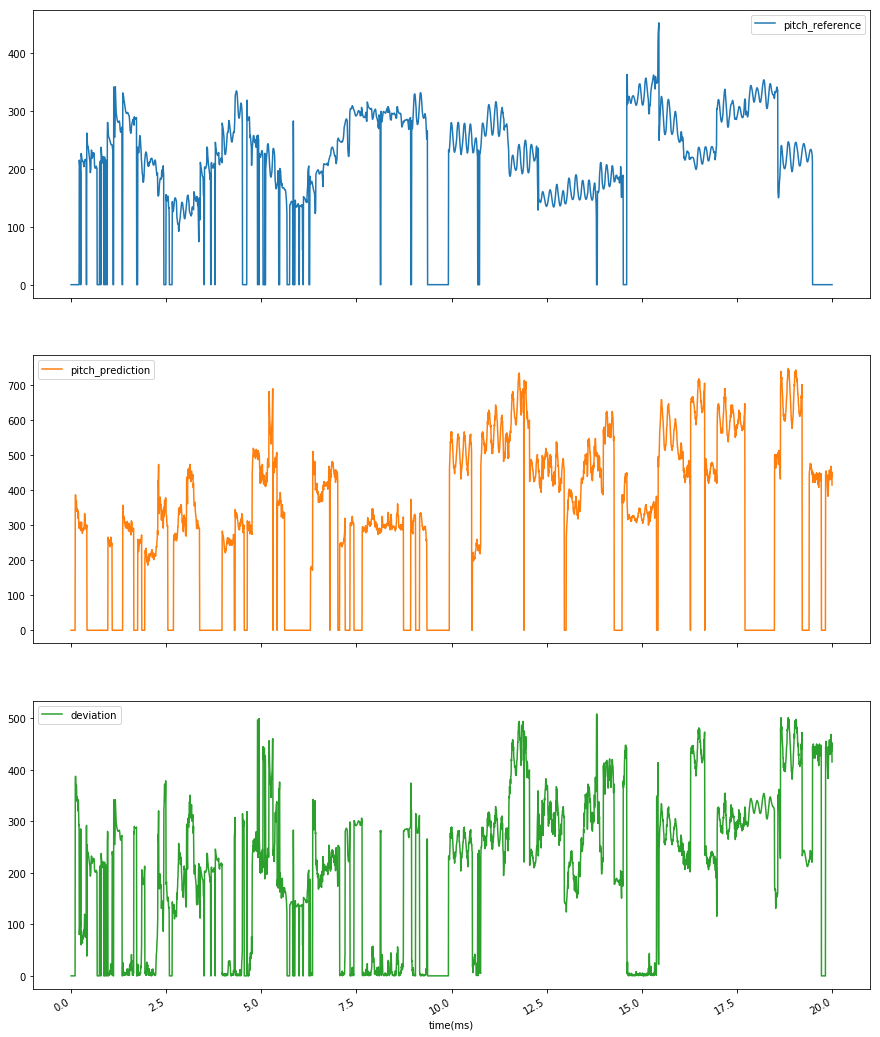

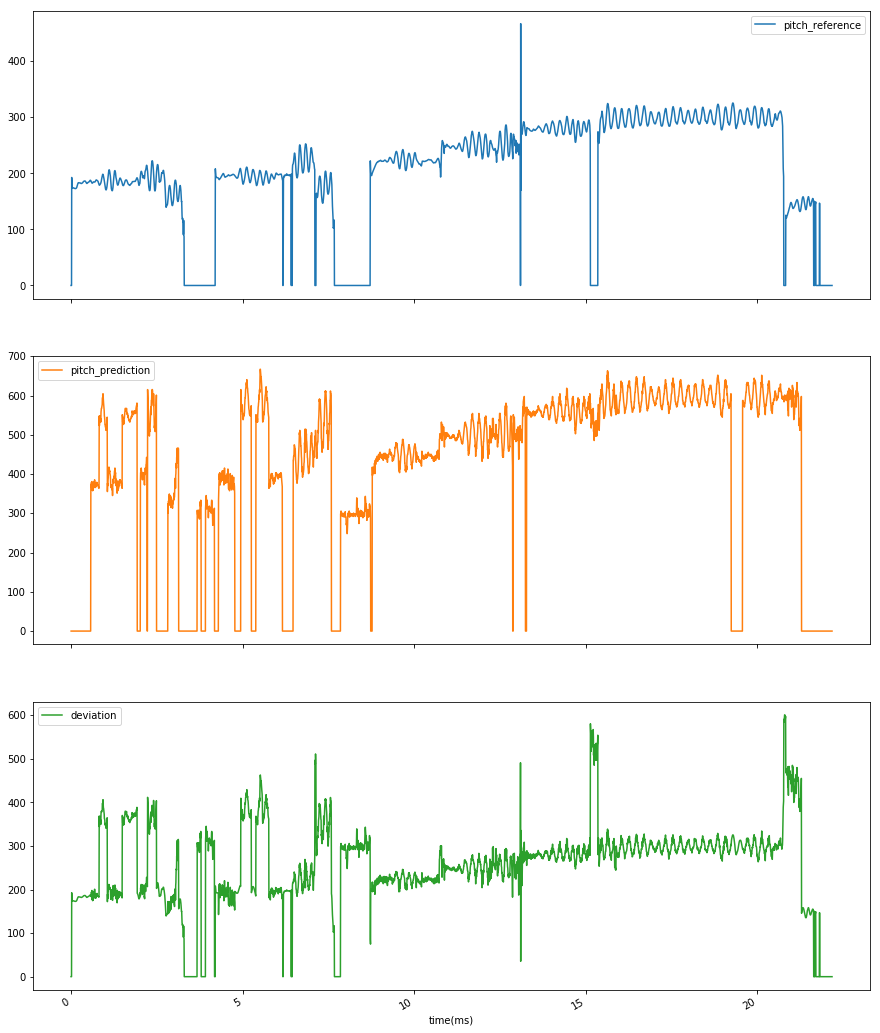

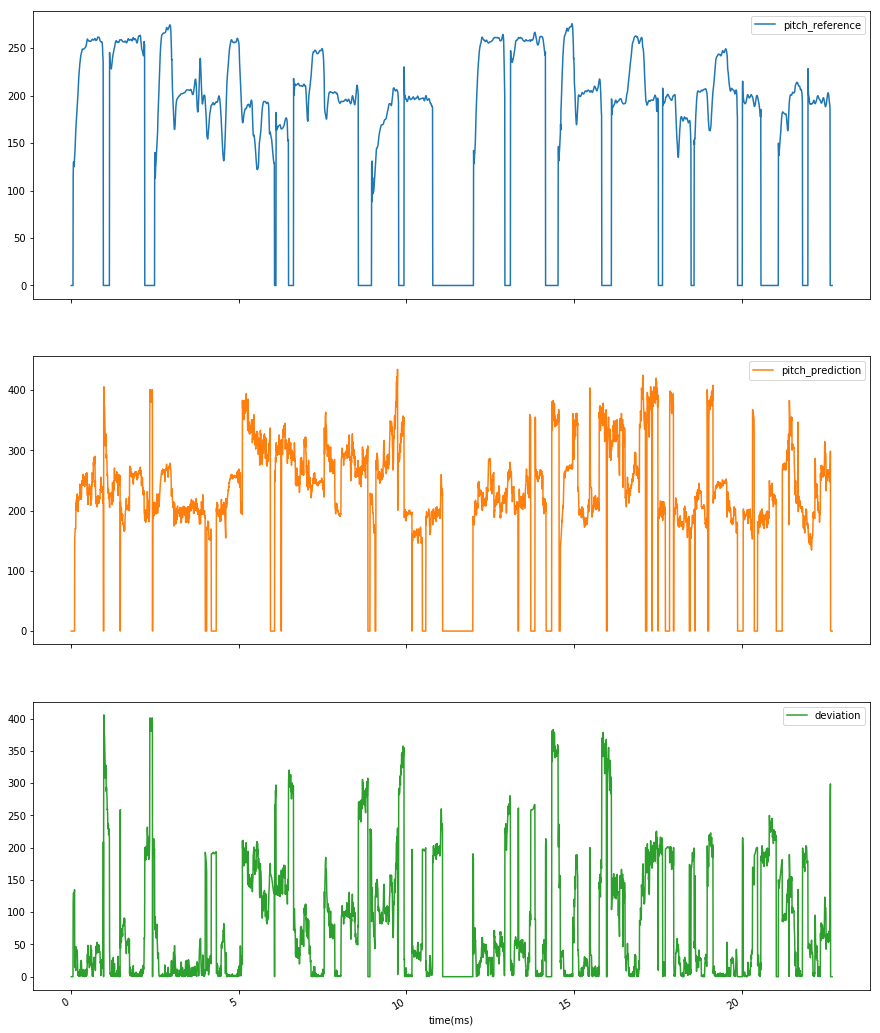

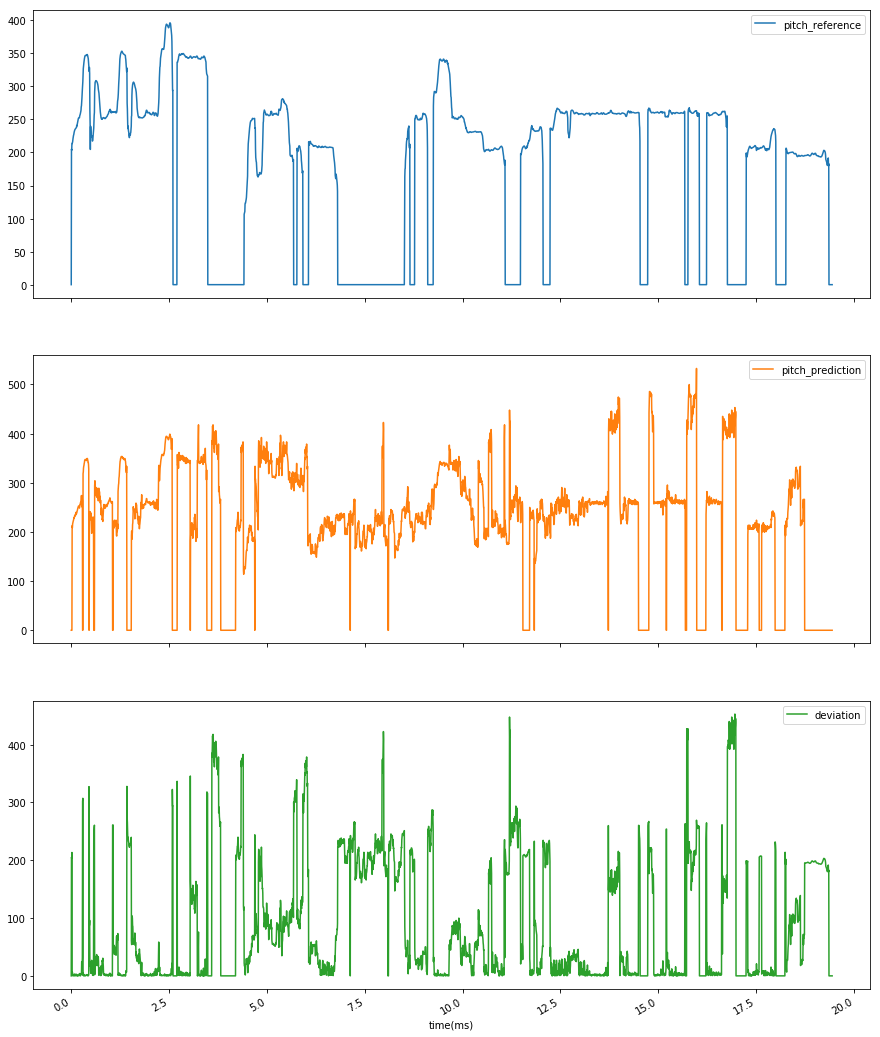

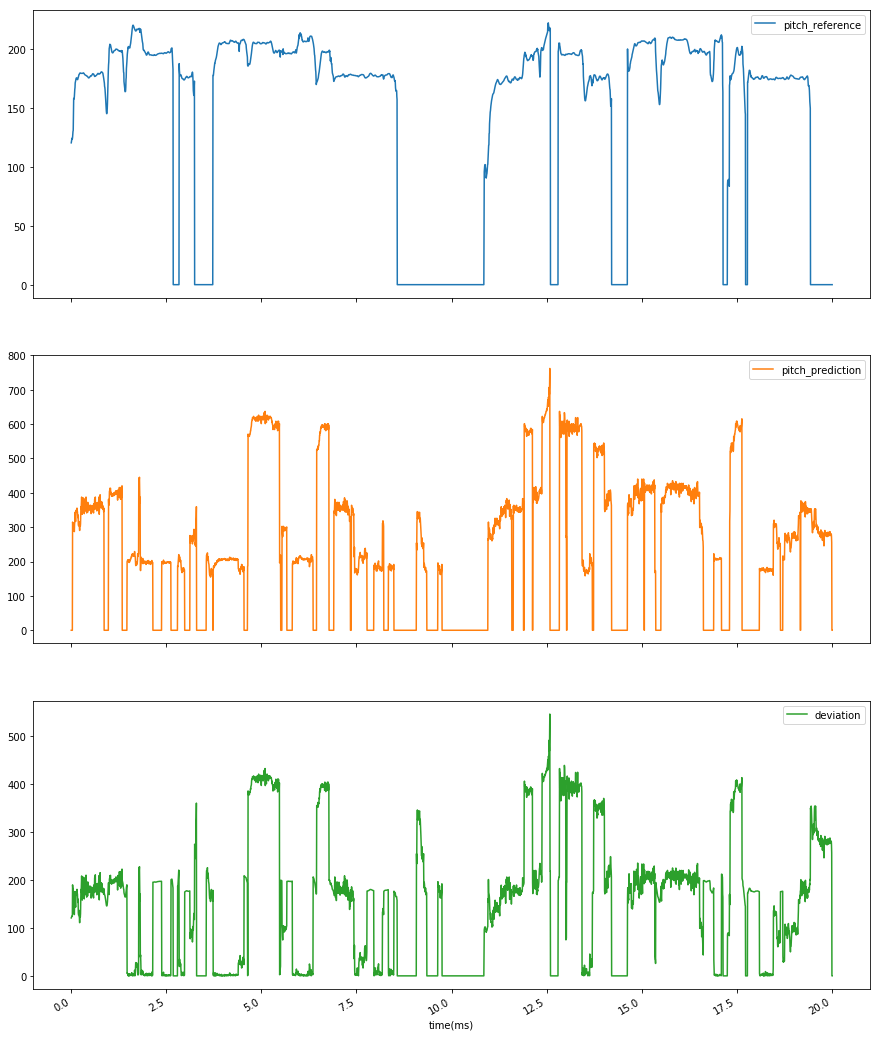

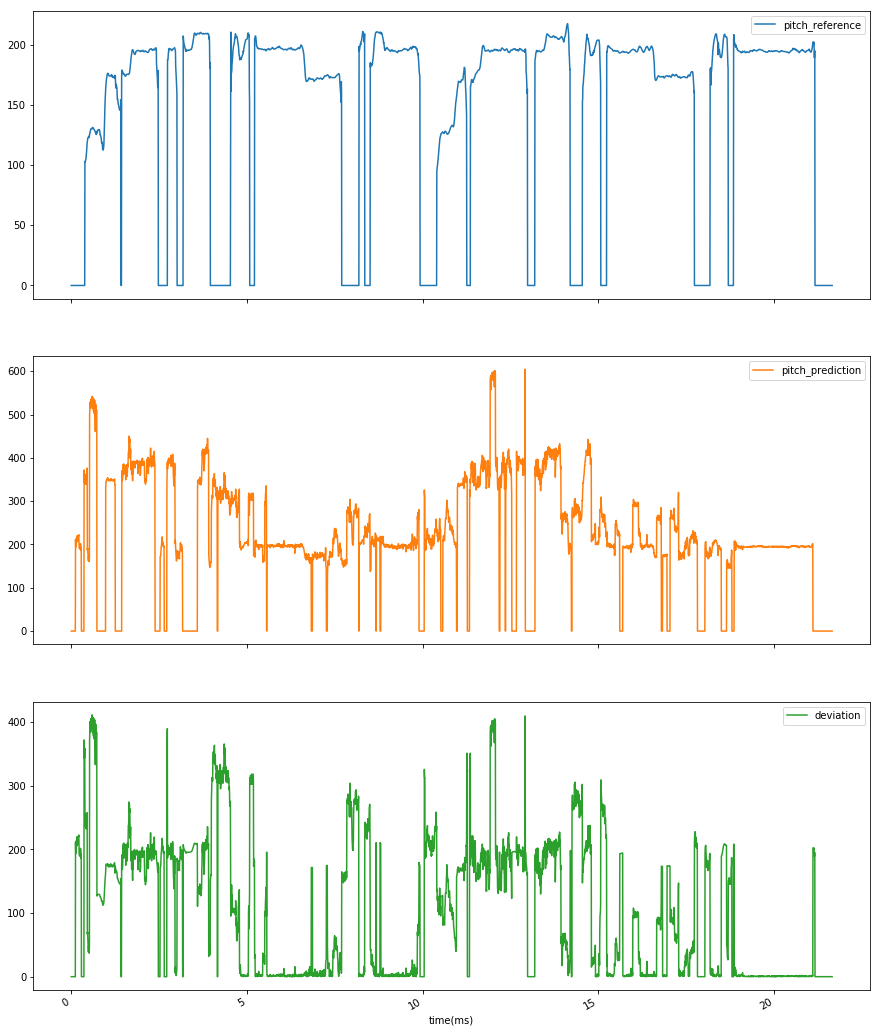

In [3]:
print("Processing Files...")

files = (f for f in os.listdir(DATASET_PATH) if f.endswith('.wav'))

if os.path.exists(ERROR_TXT_FILE): os.remove(ERROR_TXT_FILE)

with open(ERROR_TXT_FILE,"w") as txtfile:
    txtfile.write('file_name'+'\t'+'error_sum'+'\n') 
    
for file in sorted(files):
    filename,_ = os.path.splitext(file) 
    process_file(filename, DATASET_PATH);
    
print("All files were processed successfully")

